# BÁO CÁO: HỆ THỐNG GỢI Ý TẬP LUYỆN THÔNG MINH
## Data Mining Project - Gym Workout Recommendation System

**Mục tiêu:** Xây dựng hệ thống gợi ý tập luyện (Workout Recommender) sử dụng phương pháp Hybrid kết hợp K-Means Clustering, Apriori Association Rules và Machine Learning Classification.

**Phương pháp:** 
- **Module 1:** Phân cụm khách hàng (Customer Segmentation) bằng K-Means
- **Module 2:** Khai phá luật kết hợp (Pattern Mining) bằng Apriori Algorithm
- **Module 3:** Hệ thống gợi ý thông minh (Hybrid AI Recommendation System)


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style("whitegrid")


## 1. GIỚI THIỆU VÀ TẢI DỮ LIỆU

### 1.1. Mô tả bộ dữ liệu

Dự án sử dụng 2 bộ dữ liệu chính:

1. **gym_members_exercise_tracking.csv**: Dữ liệu theo dõi tập luyện của 973 thành viên phòng gym
   - Các thuộc tính: Tuổi, Giới tính, Cân nặng, Chiều cao, BMI, Tỷ lệ mỡ, Loại bài tập, Tần suất tập, Calo đốt cháy, v.v.
   
2. **megaGymDataset.csv**: Bộ dữ liệu 2918 bài tập với thông tin chi tiết
   - Các thuộc tính: Tên bài tập, Loại (Strength, Cardio, HIIT, Yoga), Độ khó (Level), Nhóm cơ, v.v.


In [31]:
df_gym = pd.read_csv('./data/gym_members_exercise_tracking.csv')
df_mega = pd.read_csv('./data/megaGymDataset.csv')

# Encode Gender
le = LabelEncoder()
df_gym['Gender_Code'] = le.fit_transform(df_gym['Gender'])

print(f"Gym Data: {df_gym.shape[0]} row, {df_gym.shape[1]} column")
print(f"MegaGym Data: {df_mega.shape[0]} row, {df_mega.shape[1]} column")
print("="*80)
print("\nBasic information about Gym data:")
print(df_gym.head())
print("="*80)
print("\nBasic information about Mega data:")
print(df_mega.head())


Gym Data: 973 row, 16 column
MegaGym Data: 2918 row, 9 column

Basic information about Gym data:
   Age  Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
0   56    Male         88.3        1.71      180      157           60   
1   46  Female         74.9        1.53      179      151           66   
2   32  Female         68.1        1.66      167      122           54   
3   25    Male         53.2        1.70      190      164           56   
4   38    Male         46.1        1.79      188      158           68   

   Session_Duration (hours)  Calories_Burned Workout_Type  Fat_Percentage  \
0                      1.69           1313.0         Yoga            12.6   
1                      1.30            883.0         HIIT            33.9   
2                      1.11            677.0       Cardio            33.4   
3                      0.59            532.0     Strength            28.8   
4                      0.64            556.0     Strength            29.2

## 2. PHÂN TÍCH DỮ LIỆU SƠ BỘ (EXPLORATORY DATA ANALYSIS - EDA)

Phần này giúp chúng ta hiểu rõ đặc điểm phân phối và mối quan hệ giữa các biến số trong dữ liệu trước khi áp dụng các thuật toán khai phá dữ liệu.


In [32]:
print(df_gym.describe())

              Age  Weight (kg)  Height (m)     Max_BPM     Avg_BPM  \
count  973.000000   973.000000   973.00000  973.000000  973.000000   
mean    38.683453    73.854676     1.72258  179.883864  143.766701   
std     12.180928    21.207500     0.12772   11.525686   14.345101   
min     18.000000    40.000000     1.50000  160.000000  120.000000   
25%     28.000000    58.100000     1.62000  170.000000  131.000000   
50%     40.000000    70.000000     1.71000  180.000000  143.000000   
75%     49.000000    86.000000     1.80000  190.000000  156.000000   
max     59.000000   129.900000     2.00000  199.000000  169.000000   

       Resting_BPM  Session_Duration (hours)  Calories_Burned  Fat_Percentage  \
count   973.000000                973.000000       973.000000      973.000000   
mean     62.223022                  1.256423       905.422405       24.976773   
std       7.327060                  0.343033       272.641516        6.259419   
min      50.000000                  0.500000 

### 2.2. Phân phối các biến số quan trọng

Vẽ histogram để xem phân phối của các biến số chính như Tuổi, Cân nặng, BMI, Tỷ lệ mỡ.


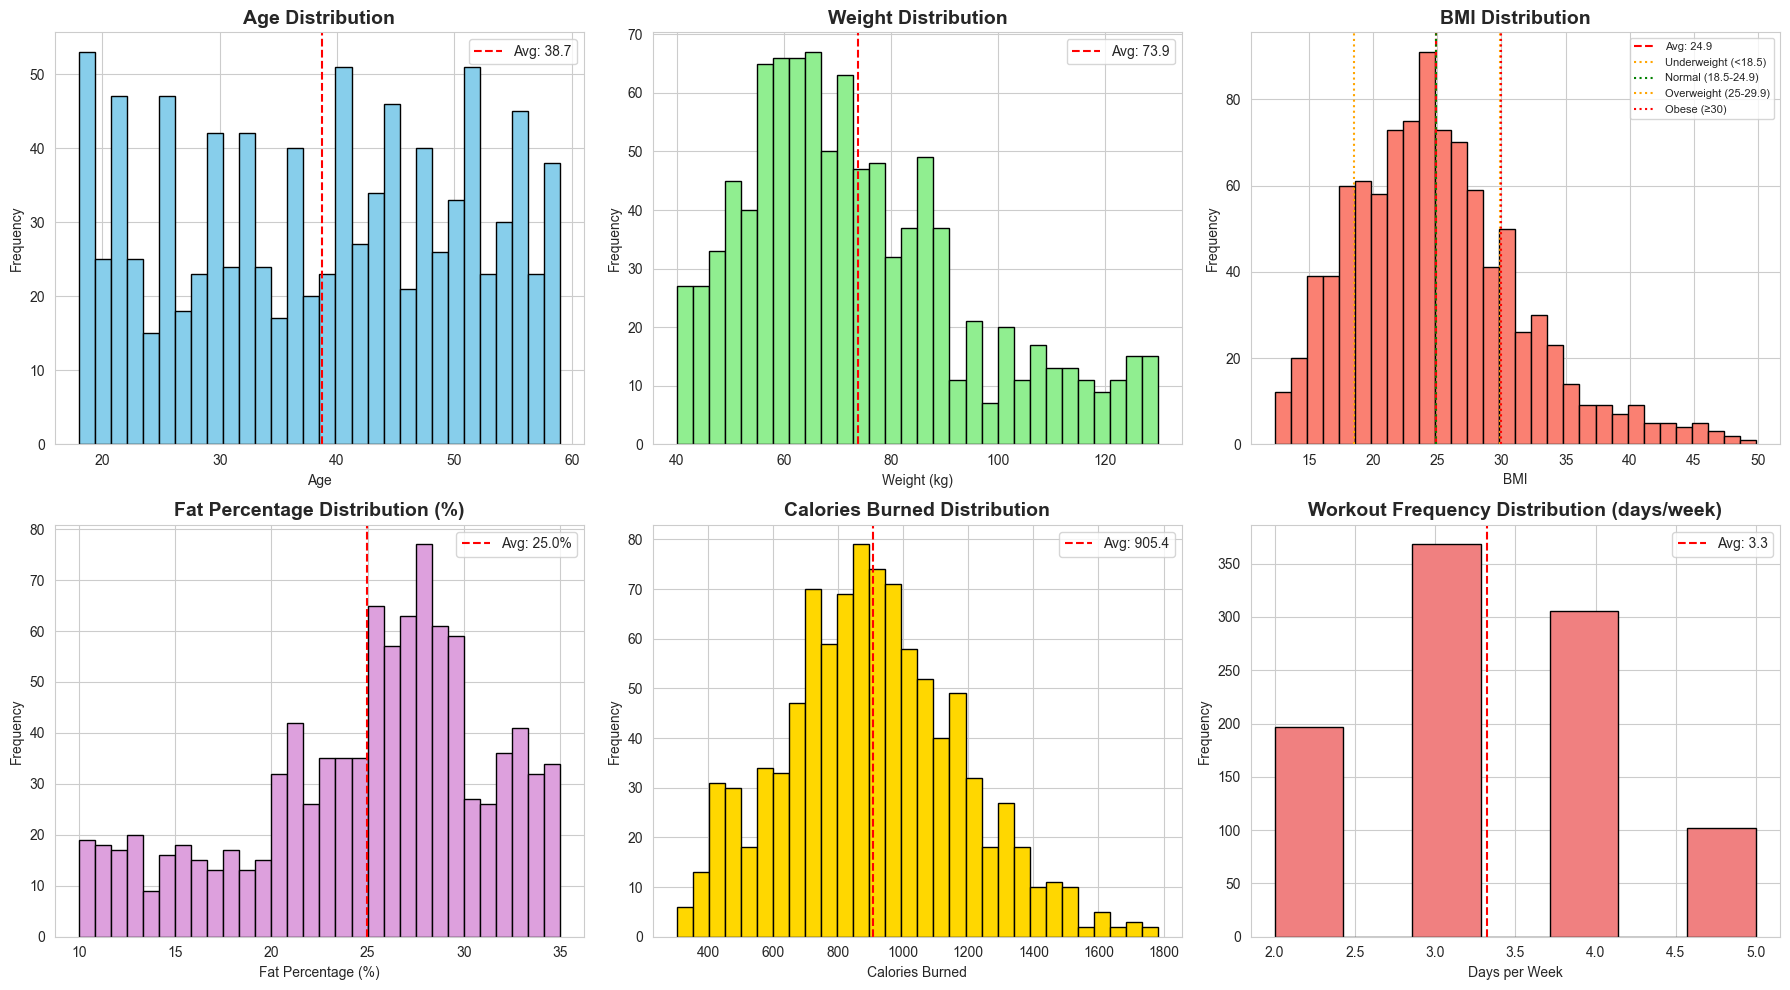

- Average age: 38.7 years (range: 18 to 59)
- Average BMI: 24.9 (range: 12.3 - 49.8)
- Average fat percentage: 25.0%
- Average workout frequency: 3.3 days/week


In [33]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Age
axes[0, 0].hist(df_gym['Age'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Age Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df_gym['Age'].mean(), color='red', linestyle='--', label=f'Avg: {df_gym["Age"].mean():.1f}')
axes[0, 0].legend()

# Weight
axes[0, 1].hist(df_gym['Weight (kg)'], bins=30, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Weight Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Weight (kg)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df_gym['Weight (kg)'].mean(), color='red', linestyle='--', label=f'Avg: {df_gym["Weight (kg)"].mean():.1f}')
axes[0, 1].legend()

# BMI
axes[0, 2].hist(df_gym['BMI'], bins=30, color='salmon', edgecolor='black')
axes[0, 2].set_title('BMI Distribution', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('BMI')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(df_gym['BMI'].mean(), color='red', linestyle='--', label=f'Avg: {df_gym["BMI"].mean():.1f}')
axes[0, 2].axvline(18.5, color='orange', linestyle=':', label='Underweight (<18.5)')
axes[0, 2].axvline(24.9, color='green', linestyle=':', label='Normal (18.5-24.9)')
axes[0, 2].axvline(29.9, color='orange', linestyle=':', label='Overweight (25-29.9)')
axes[0, 2].axvline(30, color='red', linestyle=':', label='Obese (≥30)')
axes[0, 2].legend(fontsize=8)

# Fat Percentage
axes[1, 0].hist(df_gym['Fat_Percentage'], bins=30, color='plum', edgecolor='black')
axes[1, 0].set_title('Fat Percentage Distribution (%)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Fat Percentage (%)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(df_gym['Fat_Percentage'].mean(), color='red', linestyle='--', label=f'Avg: {df_gym["Fat_Percentage"].mean():.1f}%')
axes[1, 0].legend()

# Calories Burned
axes[1, 1].hist(df_gym['Calories_Burned'], bins=30, color='gold', edgecolor='black')
axes[1, 1].set_title('Calories Burned Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Calories Burned')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(df_gym['Calories_Burned'].mean(), color='red', linestyle='--', label=f'Avg: {df_gym["Calories_Burned"].mean():.1f}')
axes[1, 1].legend()

# Workout Frequency
axes[1, 2].hist(df_gym['Workout_Frequency (days/week)'], bins=7, color='lightcoral', edgecolor='black')
axes[1, 2].set_title('Workout Frequency Distribution (days/week)', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Days per Week')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].axvline(df_gym['Workout_Frequency (days/week)'].mean(), color='red', linestyle='--', label=f'Avg: {df_gym["Workout_Frequency (days/week)"].mean():.1f}')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

print(f"- Average age: {df_gym['Age'].mean():.1f} years (range: {df_gym['Age'].min():.0f} to {df_gym['Age'].max():.0f})")
print(f"- Average BMI: {df_gym['BMI'].mean():.1f} (range: {df_gym['BMI'].min():.1f} - {df_gym['BMI'].max():.1f})")
print(f"- Average fat percentage: {df_gym['Fat_Percentage'].mean():.1f}%")
print(f"- Average workout frequency: {df_gym['Workout_Frequency (days/week)'].mean():.1f} days/week")


### 2.3. Ma trận tương quan (Correlation Matrix)

Ma trận tương quan giúp chúng ta hiểu mối quan hệ tuyến tính giữa các biến số. Điều này quan trọng để:
- Xác định các biến có tương quan mạnh (có thể gây đa cộng tuyến)
- Phát hiện các mối quan hệ thú vị (ví dụ: Cân nặng có tương quan với Calo đốt cháy không?)


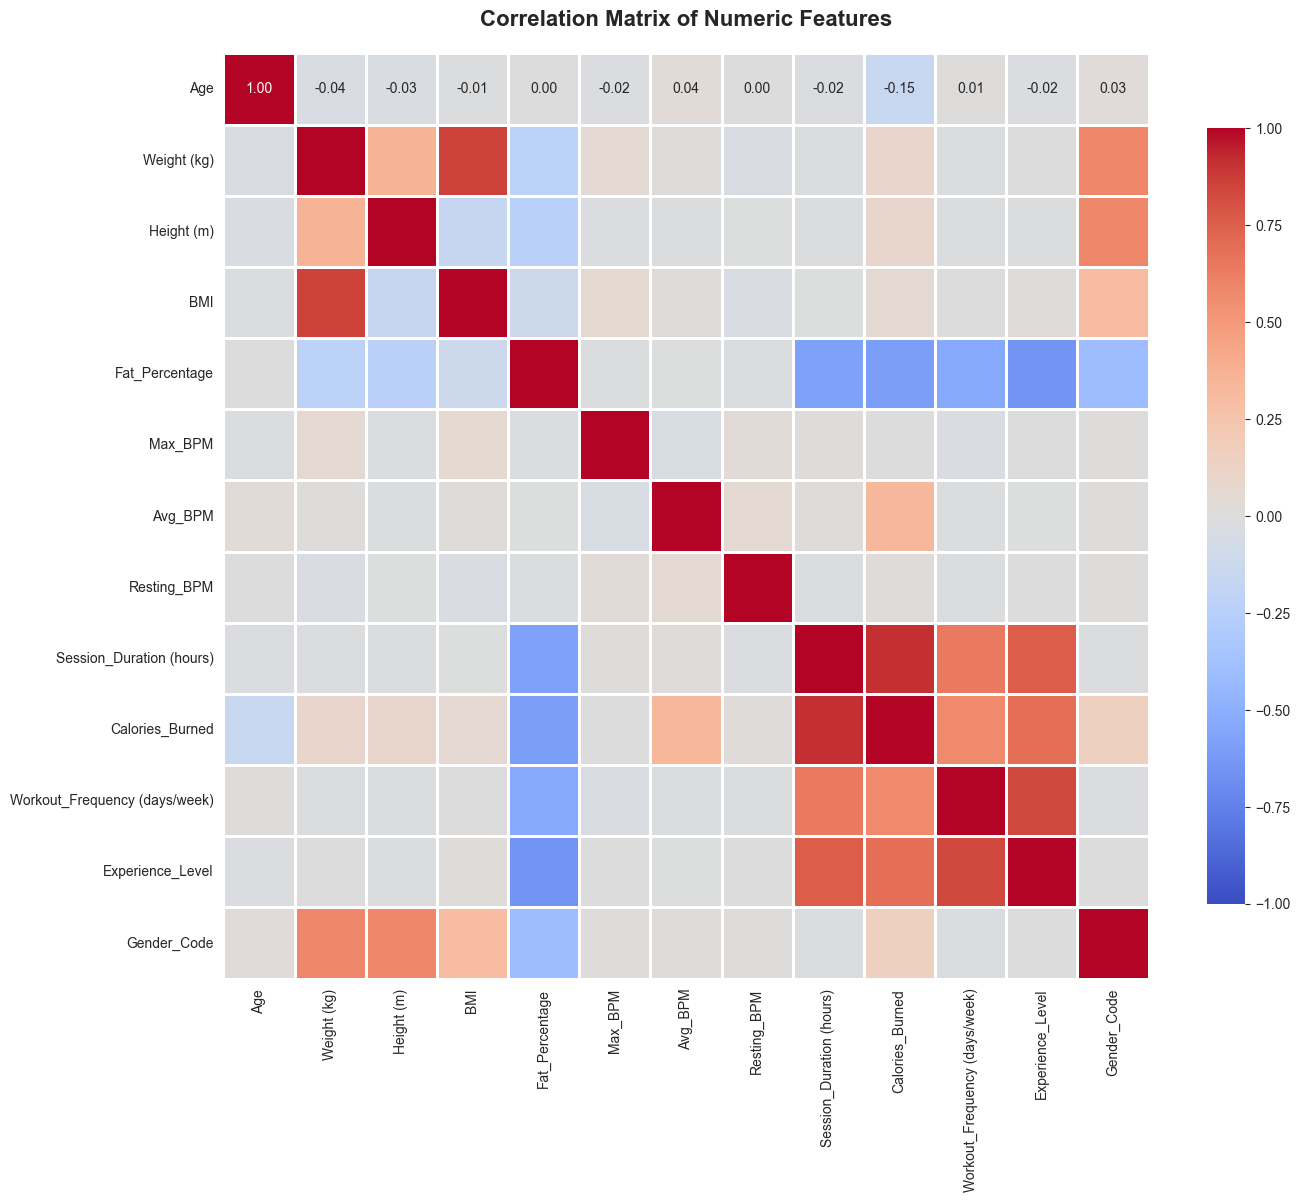


=== KEY FINDINGS ===
Variable pairs with strong correlation (|r| > 0.5):
  - Weight (kg) ↔ BMI: r = 0.853
  - Weight (kg) ↔ Gender_Code: r = 0.579
  - Height (m) ↔ Gender_Code: r = 0.584
  - Fat_Percentage ↔ Session_Duration (hours): r = -0.582
  - Fat_Percentage ↔ Calories_Burned: r = -0.598
  - Fat_Percentage ↔ Workout_Frequency (days/week): r = -0.537
  - Fat_Percentage ↔ Experience_Level: r = -0.654
  - Session_Duration (hours) ↔ Calories_Burned: r = 0.908
  - Session_Duration (hours) ↔ Workout_Frequency (days/week): r = 0.644
  - Session_Duration (hours) ↔ Experience_Level: r = 0.765
  - Calories_Burned ↔ Workout_Frequency (days/week): r = 0.576
  - Calories_Burned ↔ Experience_Level: r = 0.694
  - Workout_Frequency (days/week) ↔ Experience_Level: r = 0.837


In [34]:
numeric_cols = ['Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Fat_Percentage', 
                'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 
                'Calories_Burned', 'Workout_Frequency (days/week)', 'Experience_Level', 'Gender_Code']

corr_matrix = df_gym[numeric_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numeric Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n=== KEY FINDINGS ===")
print("Variable pairs with strong correlation (|r| > 0.5):")
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

for col1, col2, corr_val in high_corr_pairs:
    print(f"  - {col1} ↔ {col2}: r = {corr_val:.3f}")


### 2.4. Phân tích theo Loại bài tập

Xem sự phân bố và đặc điểm của các loại bài tập khác nhau trong dữ liệu.


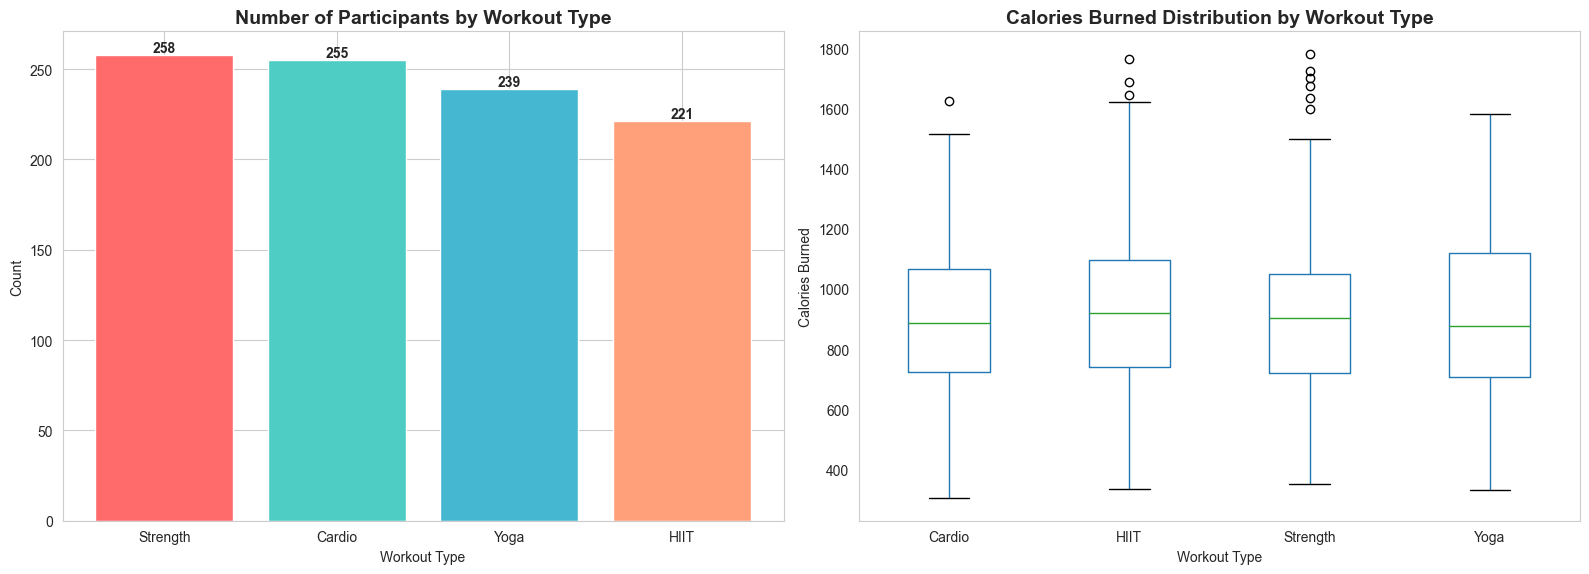


=== WORKOUT TYPE STATISTICS ===
              Calories_Burned  Session_Duration (hours)        BMI  \
Workout_Type                                                         
Cardio             884.513725                  1.220078  25.377686   
HIIT               925.805430                  1.287059  25.201946   
Strength           910.697674                  1.260155  24.543605   
Yoga               903.188285                  1.262845  24.545230   

              Fat_Percentage  
Workout_Type                  
Cardio             25.397647  
HIIT               24.461086  
Strength           25.459302  
Yoga               24.483682  


In [35]:
# Analysis by workout type
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart: Number of participants by workout type
workout_counts = df_gym['Workout_Type'].value_counts()
axes[0].bar(workout_counts.index, workout_counts.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
axes[0].set_title('Number of Participants by Workout Type', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Workout Type')
axes[0].set_ylabel('Count')
for i, v in enumerate(workout_counts.values):
    axes[0].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# Boxplot: Calories burned by workout type
df_gym.boxplot(column='Calories_Burned', by='Workout_Type', ax=axes[1], grid=False)
axes[1].set_title('Calories Burned Distribution by Workout Type', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Workout Type')
axes[1].set_ylabel('Calories Burned')
plt.suptitle('')  # Remove default suptitle

plt.tight_layout()
plt.show()

print("\n=== WORKOUT TYPE STATISTICS ===")
print(df_gym.groupby('Workout_Type')[['Calories_Burned', 'Session_Duration (hours)', 'BMI', 'Fat_Percentage']].mean())


## 3. MODULE 1: PHÂN CỤM KHÁCH HÀNG (CUSTOMER SEGMENTATION)

### 3.1. Lý thuyết K-Means Clustering

K-Means là thuật toán phân cụm không giám sát (Unsupervised Learning) nhằm phân chia dữ liệu thành K nhóm dựa trên khoảng cách Euclidean. Mục tiêu là tối thiểu hóa tổng bình phương khoảng cách từ các điểm đến tâm cụm của chúng.

**Các bước thực hiện:**
1. Chọn K tâm cụm ban đầu ngẫu nhiên
2. Gán mỗi điểm dữ liệu vào cụm gần nhất
3. Cập nhật tâm cụm bằng trung bình các điểm trong cụm
4. Lặp lại bước 2-3 cho đến khi hội tụ

### 3.2. Chọn K tối ưu bằng Elbow Method

Trước khi chạy K-Means, chúng ta cần xác định số lượng cụm (K) tối ưu. Phương pháp Elbow Method sẽ giúp tìm điểm "gãy" (elbow) trong đồ thị Inertia (tổng khoảng cách bình phương) theo K.


=== ELBOW METHOD: Finding the Optimal K ===
K = 1: Inertia = 5838.00
K = 2: Inertia = 4591.59
K = 3: Inertia = 3601.78
K = 4: Inertia = 3158.89
K = 5: Inertia = 2858.02
K = 6: Inertia = 2641.79
K = 7: Inertia = 2402.33
K = 8: Inertia = 2227.92
K = 9: Inertia = 2070.78
K = 10: Inertia = 1957.58


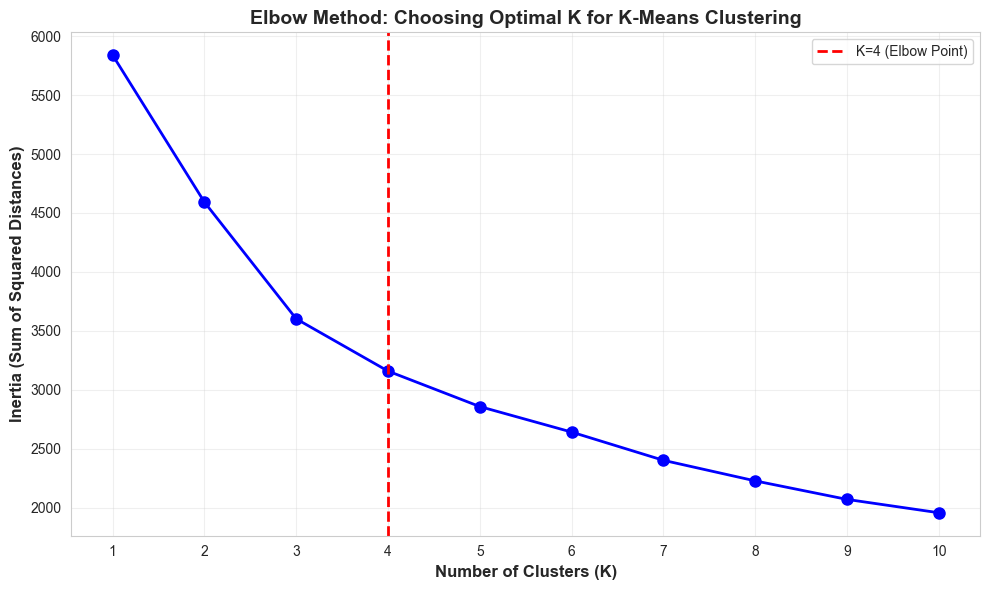

In [36]:
# Prepare data for clustering
features = ['Age', 'Gender_Code', 'BMI', 'Fat_Percentage', 'Experience_Level', 'Resting_BPM']
X = df_gym[features].copy()

# Standardize the data (important as features have different units)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method: Experiment with K from 1 to 10
inertias = []
K_range = range(1, 11)

print("=== ELBOW METHOD: Finding the Optimal K ===")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    print(f"K = {k}: Inertia = {kmeans.inertia_:.2f}")

# Plot the Elbow chart
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=12, fontweight='bold')
plt.title('Elbow Method: Choosing Optimal K for K-Means Clustering', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.axvline(x=4, color='red', linestyle='--', linewidth=2, label='K=4 (Elbow Point)')
plt.legend()
plt.tight_layout()
plt.show()

Dựa vào biểu đồ Elbow, điểm gãy rõ ràng nhất là tại K=4. Sau K=4, việc tăng thêm cụm không giảm Inertia đáng kể (diminishing returns).
→ Chọn K=4 làm số cụm tối ưu cho bài toán phân khúc khách hàng.

### 3.3. Thực hiện K-Means Clustering với K=4

Sau khi xác định K=4 là tối ưu, chúng ta tiến hành phân cụm và phân tích đặc điểm từng nhóm.


In [37]:
# Perform K-Means clustering with K=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_gym['Cluster'] = kmeans.fit_predict(X_scaled)

# Print average feature values of each cluster
print("=== AVERAGE CHARACTERISTICS OF EACH CUSTOMER GROUP ===")
cluster_stats = df_gym.groupby('Cluster')[features].mean()
print(cluster_stats.round(2))

print("\n=== NUMBER OF MEMBERS IN EACH GROUP ===")
print(df_gym['Cluster'].value_counts().sort_index())


=== AVERAGE CHARACTERISTICS OF EACH CUSTOMER GROUP ===
           Age  Gender_Code    BMI  Fat_Percentage  Experience_Level  \
Cluster                                                                
0        38.30         0.00  22.73           30.11              1.52   
1        37.38         1.00  34.24           24.91              1.52   
2        40.83         1.00  20.56           25.20              1.52   
3        38.29         0.53  24.75           14.79              3.00   

         Resting_BPM  
Cluster               
0              62.31  
1              61.36  
2              62.66  
3              62.41  

=== NUMBER OF MEMBERS IN EACH GROUP ===
Cluster
0    372
1    192
2    218
3    191
Name: count, dtype: int64


### 3.4. Trực quan hóa kết quả phân cụm

Vẽ biểu đồ scatter plot và boxplot để minh họa sự phân tách giữa các cụm.


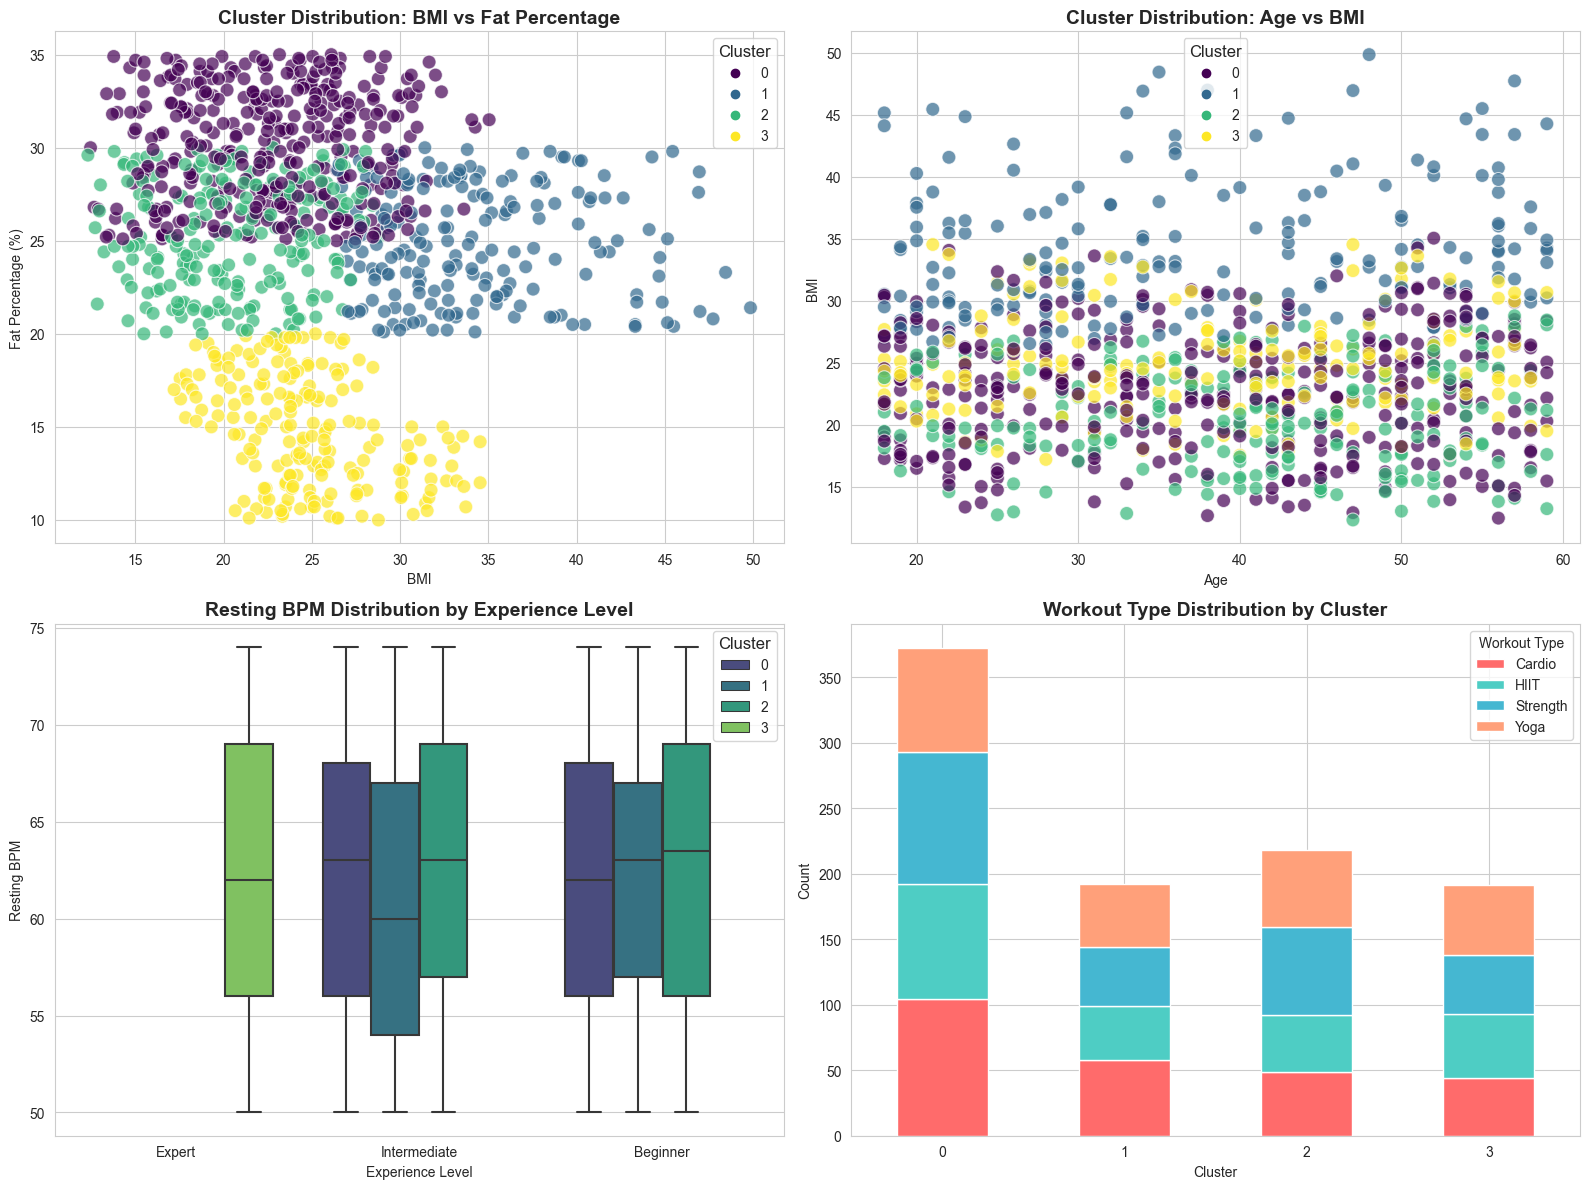

In [38]:
# Visualize clusters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: BMI vs Fat Percentage (2D)
sns.scatterplot(data=df_gym, x='BMI', y='Fat_Percentage', hue='Cluster', 
                palette='viridis', s=100, alpha=0.7, ax=axes[0, 0])
axes[0, 0].set_title('Cluster Distribution: BMI vs Fat Percentage', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('BMI')
axes[0, 0].set_ylabel('Fat Percentage (%)')
axes[0, 0].legend(title='Cluster', title_fontsize=12)

# Plot 2: Age vs BMI
sns.scatterplot(data=df_gym, x='Age', y='BMI', hue='Cluster', 
                palette='viridis', s=100, alpha=0.7, ax=axes[0, 1])
axes[0, 1].set_title('Cluster Distribution: Age vs BMI', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('BMI')
axes[0, 1].legend(title='Cluster', title_fontsize=12)

# Plot 3: Boxplot of Resting BPM by Experience Level and Cluster
df_gym['Exp_Label'] = df_gym['Experience_Level'].map({1: 'Beginner', 2: 'Intermediate', 3: 'Expert'})
sns.boxplot(data=df_gym, x='Exp_Label', y='Resting_BPM', hue='Cluster', 
            palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Resting BPM Distribution by Experience Level', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Experience Level')
axes[1, 0].set_ylabel('Resting BPM')
axes[1, 0].legend(title='Cluster', title_fontsize=12)

# Plot 4: Distribution by Cluster and Workout Type
cluster_workout = pd.crosstab(df_gym['Cluster'], df_gym['Workout_Type'])
cluster_workout.plot(kind='bar', stacked=True, ax=axes[1, 1], color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
axes[1, 1].set_title('Workout Type Distribution by Cluster', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend(title='Workout Type', title_fontsize=10)
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


### 3.5. Mô tả chi tiết 4 nhóm khách hàng

Dựa trên kết quả phân cụm, chúng ta có thể mô tả đặc điểm từng nhóm:

**Nhóm 0 (Cluster 0):** 
- Đặc điểm: BMI trung bình (~22.7), Tỷ lệ mỡ cao (~30%), Kinh nghiệm thấp-trung bình
- Ý nghĩa: Nhóm người có thể trạng bình thường nhưng tỷ lệ mỡ cao (Skinny Fat)
- Gợi ý: Cần tập HIIT hoặc Strength để giảm mỡ, tăng cơ

**Nhóm 1 (Cluster 1):**
- Đặc điểm: BMI cao (~34.2), Tỷ lệ mỡ trung bình (~24.9%), Chủ yếu là Nam
- Ý nghĩa: Nhóm người thừa cân/béo phì (BMI > 30)
- Gợi ý: Cần tập Cardio nhẹ nhàng để giảm cân an toàn

**Nhóm 2 (Cluster 2):**
- Đặc điểm: BMI thấp (~20.6), Tỷ lệ mỡ trung bình (~25.2%), Chủ yếu là Nam
- Ý nghĩa: Nhóm người gầy/thiếu cân (BMI < 18.5)
- Gợi ý: Cần tập Strength để tăng cơ, tăng cân

**Nhóm 3 (Cluster 3):**
- Đặc điểm: BMI trung bình (~24.7), Tỷ lệ mỡ thấp (~14.8%), Kinh nghiệm cao (Expert)
- Ý nghĩa: Nhóm người có thể trạng tốt, vận động viên hoặc người tập lâu năm
- Gợi ý: Có thể tập các bài nâng cao, đa dạng hóa


## 4. MODULE 2: KHAI PHÁ LUẬT KẾT HỢP (ASSOCIATION RULES MINING)

### 4.1. Lý thuyết Apriori Algorithm

Apriori là thuật toán khai phá luật kết hợp (Association Rules) để tìm ra các mẫu "Nếu... thì..." trong dữ liệu giao dịch.

**Các chỉ số quan trọng:**

1. **Support (Độ hỗ trợ):**
   - Công thức: Support(A → B) = P(A ∪ B) = Số giao dịch chứa cả A và B / Tổng số giao dịch
   - Ý nghĩa: Tần suất xuất hiện của tập itemset trong dữ liệu
   - Ví dụ: Support = 0.3 nghĩa là 30% giao dịch chứa cả A và B

2. **Confidence (Độ tin cậy):**
   - Công thức: Confidence(A → B) = P(B|A) = Support(A ∪ B) / Support(A)
   - Ý nghĩa: Xác suất B xảy ra khi A đã xảy ra
   - Ví dụ: Confidence = 0.8 nghĩa là 80% trường hợp có A thì có B

3. **Lift (Độ nâng):**
   - Công thức: Lift(A → B) = Confidence(A → B) / Support(B) = P(B|A) / P(B)
   - Ý nghĩa: Mức độ A làm tăng khả năng xảy ra của B so với ngẫu nhiên
   - Giải thích:
     - Lift = 1: A và B độc lập (không có mối quan hệ)
     - Lift > 1: A làm tăng khả năng xảy ra của B (quan hệ tích cực)
     - Lift < 1: A làm giảm khả năng xảy ra của B (quan hệ tiêu cực)
   - Ví dụ: Lift = 3.5 nghĩa là nếu có A, khả năng có B tăng gấp 3.5 lần so với ngẫu nhiên

### 4.2. Chuẩn bị dữ liệu cho Apriori

Chúng ta cần rời rạc hóa (discretize) các biến số liên tục thành các nhóm phân loại.


In [39]:
# Prepare data for Association Rules
print("=== PREPARING DATA FOR APRIORI ===")

df_ar = pd.DataFrame()
df_ar['Workout_Type'] = df_gym['Workout_Type']
df_ar['Gender'] = df_gym['Gender']
df_ar['Exp'] = df_gym['Experience_Level'].map({1: 'Beginner', 2: 'Intermediate', 3: 'Expert'})

# Binning workout frequency
df_ar['Freq'] = pd.cut(df_gym['Workout_Frequency (days/week)'], 
                       bins=[0, 2, 4, 7], 
                       labels=['Freq_Low', 'Freq_Med', 'Freq_High'])

# Binning BMI
df_ar['BMI_Group'] = pd.cut(df_gym['BMI'], 
                            bins=[0, 18.5, 24.9, 29.9, 100], 
                            labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Calculate efficiency (Calories/Hour) - the target to discover
df_gym['Efficiency_Score'] = df_gym['Calories_Burned'] / df_gym['Session_Duration (hours)']
df_ar['Efficiency'] = pd.qcut(df_gym['Efficiency_Score'], q=3, 
                               labels=['Eff_Low', 'Eff_Med', 'Eff_High'])

print("Data after discretization:")
print(df_ar.head(10))
print(f"\nNumber of samples: {len(df_ar)}")
print(f"\nEfficiency distribution:")
print(df_ar['Efficiency'].value_counts())
print(f"\nFrequency distribution:")
print(df_ar['Freq'].value_counts())


=== PREPARING DATA FOR APRIORI ===
Data after discretization:
  Workout_Type  Gender           Exp       Freq    BMI_Group Efficiency
0         Yoga    Male        Expert   Freq_Med        Obese   Eff_High
1         HIIT  Female  Intermediate   Freq_Med        Obese    Eff_Med
2       Cardio  Female  Intermediate   Freq_Med       Normal    Eff_Low
3     Strength    Male      Beginner   Freq_Med  Underweight   Eff_High
4     Strength    Male      Beginner   Freq_Med  Underweight   Eff_High
5         HIIT  Female        Expert  Freq_High       Normal    Eff_Med
6       Cardio    Male  Intermediate   Freq_Med       Normal   Eff_High
7       Cardio  Female  Intermediate   Freq_Med        Obese    Eff_Med
8     Strength    Male  Intermediate   Freq_Med        Obese    Eff_Med
9       Cardio    Male      Beginner   Freq_Med        Obese    Eff_Med

Number of samples: 973

Efficiency distribution:
Efficiency
Eff_Low     325
Eff_High    325
Eff_Med     323
Name: count, dtype: int64

Frequency 

### 4.3. Áp dụng Apriori Algorithm

Sử dụng thuật toán Apriori để tìm các itemset thường xuyên và luật kết hợp.


In [40]:
# One-Hot Encoding for Apriori
df_ohe = pd.get_dummies(df_ar)
print(f"Number of variables after One-Hot Encoding: {df_ohe.shape[1]}")

# Find frequent itemsets with min_support = 0.05 (5%)
print("\n=== FINDING FREQUENT ITEMSETS (min_support=0.05) ===")
frequent_itemsets = apriori(df_ohe, min_support=0.05, use_colnames=True)
print(f"Number of frequent itemsets found: {len(frequent_itemsets)}")
print("\nTop 10 Frequent Itemsets:")
print(frequent_itemsets.sort_values('support', ascending=False).head(10))

# Generate Association Rules with min_lift = 1.1
print("\n=== GENERATING ASSOCIATION RULES (min_lift=1.1) ===")
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.1)
print(f"Number of rules found: {len(rules)}")
print("\nTop 10 Rules with Highest Lift:")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values('lift', ascending=False).head(10))


Number of variables after One-Hot Encoding: 19

=== FINDING FREQUENT ITEMSETS (min_support=0.05) ===
Number of frequent itemsets found: 275

Top 10 Frequent Itemsets:
      support                           itemsets
10   0.692703                    (Freq_Freq_Med)
5    0.525180                      (Gender_Male)
4    0.474820                    (Gender_Female)
106  0.417266  (Exp_Intermediate, Freq_Freq_Med)
8    0.417266                 (Exp_Intermediate)
6    0.386434                     (Exp_Beginner)
13   0.376156                 (BMI_Group_Normal)
81   0.355601       (Gender_Male, Freq_Freq_Med)
70   0.337102     (Freq_Freq_Med, Gender_Female)
16   0.334018               (Efficiency_Eff_Low)

=== GENERATING ASSOCIATION RULES (min_lift=1.1) ===
Number of rules found: 528

Top 10 Rules with Highest Lift:
                            antecedents                         consequents  \
296                    (Freq_Freq_High)      (BMI_Group_Normal, Exp_Expert)   
293      (BMI_Group_Nor

### 4.4. Phân tích các luật dẫn đến Hiệu quả cao

Chúng ta tập trung vào các luật có kết quả là "Efficiency_High" (hiệu quả đốt calo cao).


In [41]:
# Filter rules leading to high efficiency (Efficiency_High)
success_rules = rules[rules['consequents'].astype(str).str.contains('Efficiency_Eff_High')]
success_rules = success_rules.sort_values('lift', ascending=False)

print("=== TOP 5 RULES LEADING TO HIGH EFFICIENCY ===")
print(success_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(5))

print("\n=== DETAILED EXPLANATION OF METRICS ===")
for idx, row in success_rules.head(5).iterrows():
    print(f"\nRule {idx}:")
    print(f"  If: {row['antecedents']}")
    print(f"  Then: {row['consequents']}")
    print(f"  Support = {row['support']:.3f} → {row['support']*100:.1f}% of transactions contain both the antecedent and the consequent")
    print(f"  Confidence = {row['confidence']:.3f} → {row['confidence']*100:.1f}% of transactions with the antecedent also have the consequent")
    print(f"  Lift = {row['lift']:.3f} → The likelihood of achieving high efficiency increases by {row['lift']:.2f} times compared to random")

=== TOP 5 RULES LEADING TO HIGH EFFICIENCY ===
                      antecedents  \
460   (Exp_Beginner, Gender_Male)   
462  (Gender_Male, Freq_Freq_Low)   
289               (Freq_Freq_Low)   
466               (Freq_Freq_Low)   
464                (Exp_Beginner)   

                                           consequents   support  confidence  \
460               (Freq_Freq_Low, Efficiency_Eff_High)  0.051387    0.253807   
462                (Exp_Beginner, Efficiency_Eff_High)  0.051387    0.454545   
289                (Exp_Beginner, Efficiency_Eff_High)  0.068859    0.340102   
466   (Exp_Beginner, Gender_Male, Efficiency_Eff_High)  0.051387    0.253807   
464  (Gender_Male, Freq_Freq_Low, Efficiency_Eff_High)  0.051387    0.132979   

         lift  
460  3.685885  
462  3.685606  
289  2.757657  
466  2.743937  
464  2.587766  

=== DETAILED EXPLANATION OF METRICS ===

Rule 460:
  If: frozenset({'Exp_Beginner', 'Gender_Male'})
  Then: frozenset({'Freq_Freq_Low', 'Efficiency_Eff_

**Insight từ Top 5 luật dẫn đến Efficiency_High**
Các luật có lift ~2.6–3.7 cho thấy pattern nhất quán:

- **Freq_Low** là yếu tố mạnh nhất: khi tần suất sử dụng thấp, xác suất đạt hiệu suất cao tăng đáng kể (nhiều luật xoay quanh Freq_Freq_Low).
- **Beginner** xuất hiện thường xuyên trong consequents → người mới có xu hướng hiệu quả cao hơn mức kỳ vọng.
- **Gender_Male** chỉ là biến bổ trợ, không phải yếu tố quyết định nhưng xuất hiện nhiều trong các kết hợp nâng lift.

**Tóm tắt:** Nhóm đạt Efficiency_High chủ yếu rơi vào **Beginner + Freq_Low**, đôi khi kèm Male. Lift cao nghĩa là những tổ hợp này làm tăng khả năng đạt hiệu suất cao so với ngẫu nhiên.


### 4.5. Trực quan hóa Association Rules

Vẽ biểu đồ để minh họa mối quan hệ giữa Support, Confidence và Lift.


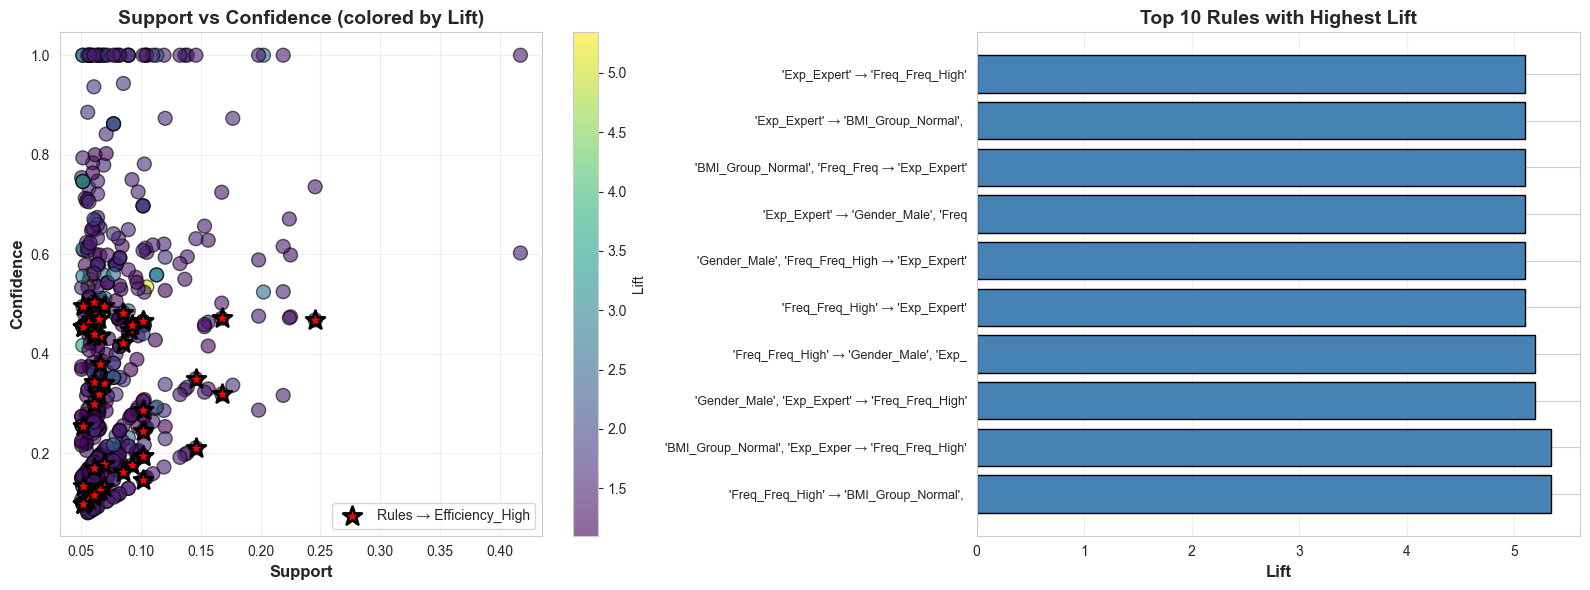

In [42]:
# Visualization of Association Rules
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Support vs Confidence (color by Lift)
scatter = axes[0].scatter(
    rules['support'],
    rules['confidence'],
    c=rules['lift'],
    cmap='viridis',
    s=100,
    alpha=0.6,
    edgecolors='black'
)
axes[0].set_xlabel('Support', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Confidence', fontsize=12, fontweight='bold')
axes[0].set_title('Support vs Confidence (colored by Lift)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=axes[0], label='Lift')
axes[0].grid(True, alpha=0.3)

# Highlight rules leading to Efficiency_High
high_eff_rules = rules[rules['consequents'].astype(str).str.contains('Efficiency_Eff_High')]
axes[0].scatter(
    high_eff_rules['support'],
    high_eff_rules['confidence'],
    c='red',
    s=200,
    marker='*',
    edgecolors='black',
    linewidth=2,
    label='Rules → Efficiency_High',
    zorder=5
)
axes[0].legend()

# Plot 2: Top 10 rules with highest Lift
top_rules = rules.nlargest(10, 'lift')
y_pos = np.arange(len(top_rules))
axes[1].barh(y_pos, top_rules['lift'], color='steelblue', edgecolor='black')
axes[1].set_yticks(y_pos)
# Create concise labels for each rule
labels = []
for idx, row in top_rules.iterrows():
    ant = str(row['antecedents']).replace('frozenset({', '').replace('})', '')[:30]
    cons = str(row['consequents']).replace('frozenset({', '').replace('})', '')[:20]
    labels.append(f"{ant} → {cons}")
axes[1].set_yticklabels(labels, fontsize=9)
axes[1].set_xlabel('Lift', fontsize=12, fontweight='bold')
axes[1].set_title('Top 10 Rules with Highest Lift', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


Dataset nổi bật với **hai nhóm hành vi chính**:

1. **Power Users**  
   - `Exp_Expert ↔ Freq_Freq_High`  
   - Lift rất cao (>5), hành vi nhất quán.  
   - Thường đi kèm `BMI_Normal`, `Gender_Male`.  
   → Tần suất sử dụng cao là chỉ báo mạnh nhất của Expert.

2. **Efficient Casuals**  
   - `Freq_Low + Exp_Beginner` (đôi khi kèm Male).  
   - Lift trung bình (2–3).  
   → Beginner dùng ít nhưng lại có hiệu suất cao hơn kỳ vọng.

Hai cluster này tạo nên cấu trúc hành vi rõ nhất trong toàn bộ tập luật.


## 5. MODULE 3: HỆ THỐNG GỢI Ý THÔNG MINH (RECOMMENDATION SYSTEM)


### 5.1. Mô hình trên dữ liệu gốc (Baseline)


=== EXPERIMENT 1: MODEL ON ORIGINAL DATA ===
Accuracy: 24.10%

Detailed classification report:
              precision    recall  f1-score   support

      Cardio       0.17      0.17      0.17        46
        HIIT       0.30      0.33      0.31        42
    Strength       0.24      0.32      0.28        47
        Yoga       0.26      0.17      0.20        60

    accuracy                           0.24       195
   macro avg       0.24      0.25      0.24       195
weighted avg       0.24      0.24      0.24       195



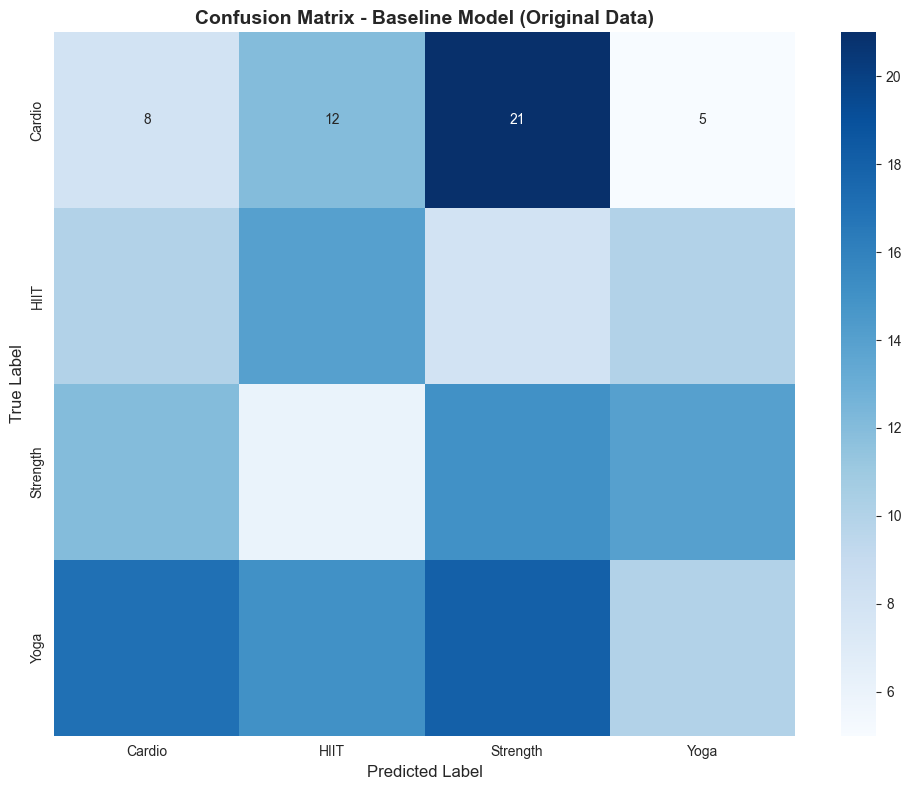

In [43]:
# EXPERIMENT 1: Train model on original data (actual Workout_Type)
print("=== EXPERIMENT 1: MODEL ON ORIGINAL DATA ===")

# Use actual Workout_Type as label (may be incorrect)
X_baseline = df_gym[['Age', 'Gender_Code', 'BMI', 'Fat_Percentage', 'Experience_Level']]
y_baseline = df_gym['Workout_Type']  # Labels from original data

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_baseline, y_baseline, test_size=0.2, random_state=42
)

# Train Random Forest
model_baseline = RandomForestClassifier(n_estimators=100, random_state=42)
model_baseline.fit(X_train_base, y_train_base)

# Evaluation
y_pred_base = model_baseline.predict(X_test_base)
acc_baseline = accuracy_score(y_test_base, y_pred_base)

print(f"Accuracy: {acc_baseline*100:.2f}%")
print("\nDetailed classification report:")
print(classification_report(y_test_base, y_pred_base))

# Confusion Matrix
cm_baseline = confusion_matrix(y_test_base, y_pred_base)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model_baseline.classes_, 
            yticklabels=model_baseline.classes_)
plt.title('Confusion Matrix - Baseline Model (Original Data)', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()



Ban đầu, chúng ta thử nghiệm xây dựng mô hình phân loại (Classification) sử dụng Random Forest trên dữ liệu gốc để dự đoán loại bài tập phù hợp dựa trên đặc điểm người dùng.

**Kết quả:** Độ chính xác chỉ đạt **~24%** - gần như ngang với đoán mò (random guess).

**Nguyên nhân phân tích:**
- Dữ liệu hành vi lịch sử mang tính cảm tính, không khoa học
- Người dùng thường chọn bài tập sai khoa học (ví dụ: Người béo phì chọn bài nhảy cao gây hại khớp)
- Mô hình học máy học từ dữ liệu sai → Đưa ra gợi ý sai

### 5.2. Giải pháp: Expert Labeling (Gán nhãn chuyên gia)

Thay vì học từ dữ liệu sai, chúng ta áp dụng kỹ thuật **Expert Labeling**: Chuẩn hóa lại dữ liệu đích dựa trên logic y khoa và kiến thức chuyên môn về thể dục.

### **Bộ quy tắc**

1. **BMI ≥ 30**  
   → Gán: **Cardio** (ưu tiên bài tập low-impact, giảm mỡ an toàn)

2. **BMI < 30 và Age ≥ 55**  
   → Gán: **Yoga** (tăng dẻo dai, giảm rủi ro chấn thương)

3. **BMI < 18.5**  
   → Gán: **Strength** (ưu tiên tăng cơ, cải thiện khối nạc)

4. **Skinny Fat** *(BMI < 30 + %mỡ cao)*  
   - Nam: Fat% > 25  
   - Nữ: Fat% > 32  
   → Gán: **HIIT** (tối ưu đốt mỡ và cải thiện body recomposition)

5. **Mặc định (fallback rule)**  
   - Nam → **Strength**  
   - Nữ → **Yoga**

Các quy tắc được sắp theo thứ tự ưu tiên để tránh chồng chéo và giúp mô hình học từ dữ liệu được chuẩn hóa thay vì dữ liệu chọn sai từ người dùng.



In [44]:
def expert_labeling_logic(row):
    """
    Expert Labeling: Normalize target labels based on medical/fitness knowledge
    instead of learning from potentially incorrect user choices.
    """
    bmi = row['BMI']
    age = row['Age']
    gender = row['Gender_Code']  # 1=Male, 0=Female
    fat = row['Fat_Percentage']
    
    # 1. High BMI (obesity) → prioritize safety
    if bmi >= 30:
        return 'Cardio'
    
    # 2. Older adults → prioritize injury risk reduction
    if age >= 55:
        return 'Yoga'
    
    # 3. Underweight individuals → focus on gaining muscle
    if bmi < 18.5:
        return 'Strength'
    
    # 4. Skinny Fat (high fat but BMI < 30)
    if gender == 1 and fat > 25:  # Male
        return 'HIIT'
    if gender == 0 and fat > 32:  # Female
        return 'HIIT'
    
    # 5. Fallback by general trend
    return 'Strength' if gender == 1 else 'Yoga'


# Apply Expert Labeling
print("=== APPLYING EXPERT LABELING ===")
df_gym['Target_Workout'] = df_gym.apply(expert_labeling_logic, axis=1)

print("Label distribution after Expert Labeling:")
print(df_gym['Target_Workout'].value_counts())

print("\nComparison with original data:")
print("Original data (Workout_Type):")
print(df_gym['Workout_Type'].value_counts())

print("\nExpert label (Target_Workout):")
print(df_gym['Target_Workout'].value_counts())


=== APPLYING EXPERT LABELING ===
Label distribution after Expert Labeling:
Target_Workout
Yoga        308
Strength    301
Cardio      192
HIIT        172
Name: count, dtype: int64

Comparison with original data:
Original data (Workout_Type):
Workout_Type
Strength    258
Cardio      255
Yoga        239
HIIT        221
Name: count, dtype: int64

Expert label (Target_Workout):
Target_Workout
Yoga        308
Strength    301
Cardio      192
HIIT        172
Name: count, dtype: int64


### 5.3. Thử nghiệm 2: Mô hình sau khi áp dụng Expert Labeling


=== EXPERIMENT 2: MODEL AFTER EXPERT LABELING ===
Accuracy: 100.00%

Detailed classification report:
              precision    recall  f1-score   support

      Cardio       1.00      1.00      1.00        39
        HIIT       1.00      1.00      1.00        32
    Strength       1.00      1.00      1.00        66
        Yoga       1.00      1.00      1.00        58

    accuracy                           1.00       195
   macro avg       1.00      1.00      1.00       195
weighted avg       1.00      1.00      1.00       195



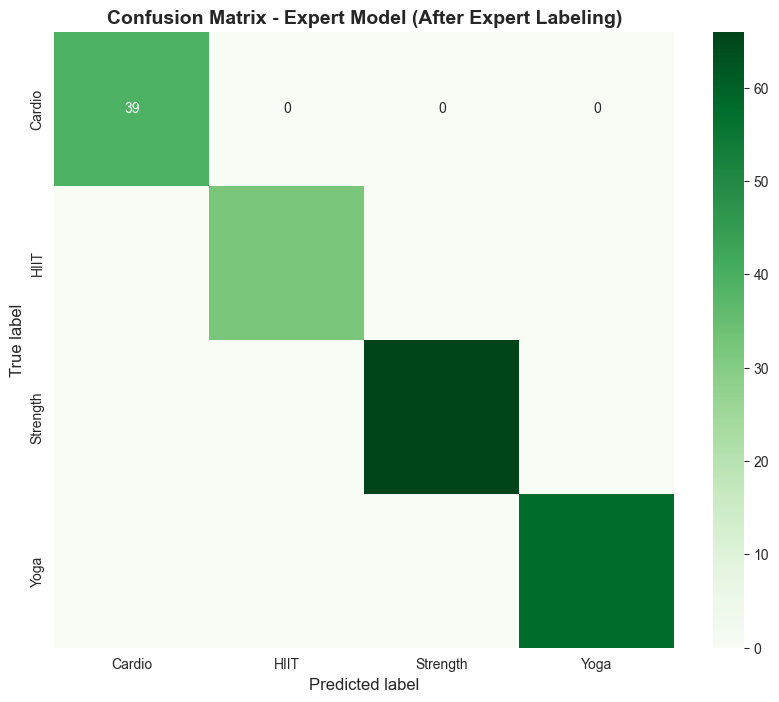

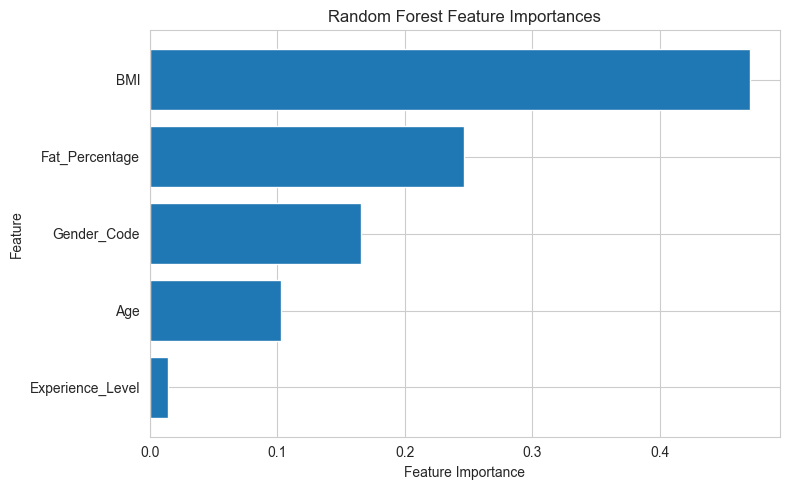

In [45]:
# EXPERIMENT 2: Train model on data after Expert Labeling
print("=== EXPERIMENT 2: MODEL AFTER EXPERT LABELING ===")

X_expert = df_gym[['Age', 'Gender_Code', 'BMI', 'Fat_Percentage', 'Experience_Level']]
y_expert = df_gym['Target_Workout']  # Labels from Expert Labeling

X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(
    X_expert, y_expert, test_size=0.2, random_state=42
)

# Train Random Forest
model_expert = RandomForestClassifier(n_estimators=100, random_state=42)
model_expert.fit(X_train_exp, y_train_exp)

# Evaluation
y_pred_exp = model_expert.predict(X_test_exp)
acc_expert = accuracy_score(y_test_exp, y_pred_exp)

print(f"Accuracy: {acc_expert*100:.2f}%")
print("\nDetailed classification report:")
print(classification_report(y_test_exp, y_pred_exp))

# Confusion Matrix
cm_expert = confusion_matrix(y_test_exp, y_pred_exp)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_expert, annot=True, fmt='d', cmap='Greens', 
            xticklabels=model_expert.classes_, 
            yticklabels=model_expert.classes_)
plt.title('Confusion Matrix - Expert Model (After Expert Labeling)', fontsize=14, fontweight='bold')
plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)

feature_importances = pd.DataFrame({
    'Feature': X_expert.columns,
    'Importance': model_expert.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()  

plt.tight_layout()
plt.show()


### 5.5. So sánh kết quả: Trước và Sau Expert Labeling

Vẽ biểu đồ so sánh trực quan để thể hiện sự cải thiện.


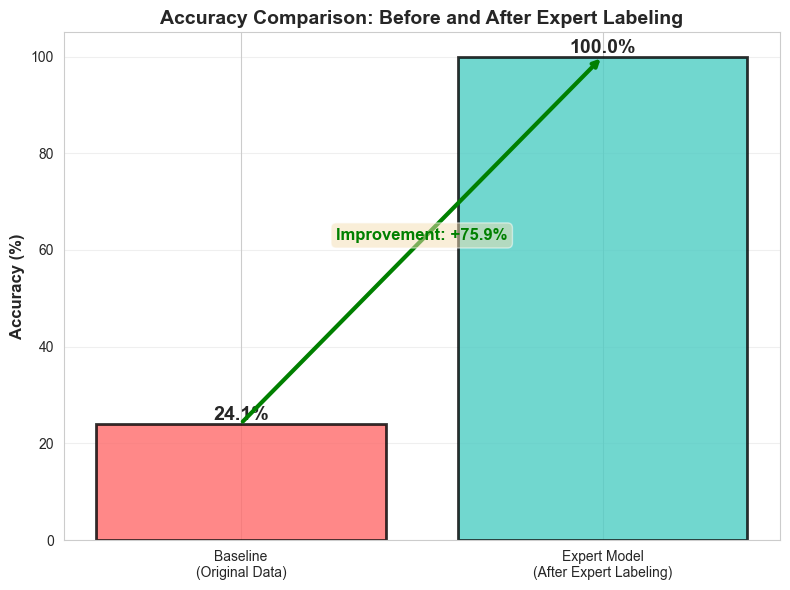

In [46]:
fig, ax = plt.subplots(figsize=(8, 6))

models = ['Baseline\n(Original Data)', 'Expert Model\n(After Expert Labeling)']
accuracies = [acc_baseline * 100, acc_expert * 100]
colors = ['#FF6B6B', '#4ECDC4']

bars = ax.bar(models, accuracies, color=colors, edgecolor='black', linewidth=2, alpha=0.8)
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Accuracy Comparison: Before and After Expert Labeling', fontsize=14, fontweight='bold')
ax.set_ylim([0, 105])
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Draw improvement arrow
ax.annotate('', xy=(1, acc_expert * 100), xytext=(0, acc_baseline * 100),
            arrowprops=dict(arrowstyle='->', lw=3, color='green'))
ax.text(0.5, (acc_baseline + acc_expert) * 50,
        f'Improvement: +{(acc_expert - acc_baseline)*100:.1f}%',
        ha='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


### Vì sao accuracy = 100%?
Do nhãn *Target_Workout* được tạo **trực tiếp từ chính các feature** bằng Expert Labeling, mô hình chỉ cần học lại đúng các rule đã đặt (BMI, tuổi, mỡ, giới tính…). Random Forest rất giỏi với dạng rule-based → nên tái tạo 100% là bình thường.

### Feature Importance

- **BMI (cao nhất)**: Chi phối 2 rule lớn (béo phì → Cardio, thiếu cân → Strength).
- **Fat_Percentage**: Quyết định nhóm Skinny Fat → HIIT.
- **Gender_Code**: Quy định fallback Strength/Yoga.
- **Age**: Chỉ tác động khi ≥ 55 nên importance thấp hơn.
- **Experience_Level (thấp nhất)**: Không nằm trong bất kỳ rule chính → gần như không góp phần.

→ Mô hình phản ánh chính xác logic chuyên gia: BMI & Fat% là hai yếu tố quyết định mạnh nhất.


### 5.6. Hàm gợi ý cuối cùng (Recommendation Function)

Sau khi đã có mô hình tốt, chúng ta xây dựng hàm gợi ý hoàn chỉnh kết hợp:
- **Macro Recommendation:** AI dự đoán loại bài tập phù hợp (Strength, Cardio, HIIT, Yoga)
- **Micro Recommendation:** Lấy danh sách bài tập chi tiết từ MegaGymDataset


In [47]:
def get_recommendation(model, df_mega, user_info):
    """
    Final recommendation function for users.

    Parameters:
    - model: Trained Random Forest model
    - df_mega: DataFrame containing the list of exercises
    - user_info: Dictionary with user information (age, gender, weight, height, experience)

    Returns:
    - Dictionary with detailed recommendations
    """
    # 1. Parse Input
    age = user_info['age']
    gender = user_info['gender']
    weight = user_info['weight']
    height = user_info['height']
    exp_str = user_info['experience']
    
    # Calculate metrics
    bmi = weight / (height * height)
    gender_code = 1 if gender.lower() == 'male' else 0
    
    # Estimate body fat (if not measured) - Uses Deurenberg formula
    if gender_code == 1:
        est_fat = (1.20 * bmi) + (0.23 * age) - 16.2
    else:
        est_fat = (1.20 * bmi) + (0.23 * age) - 5.4
        
    exp_val = {'Beginner': 1, 'Intermediate': 2, 'Expert': 3}.get(exp_str.capitalize(), 1)
    
    # 2. AI Prediction (Macro Recommendation)
    user_vector = pd.DataFrame([[age, gender_code, bmi, est_fat, exp_val]], 
                               columns=['Age', 'Gender_Code', 'BMI', 'Fat_Percentage', 'Experience_Level'])
    pred_workout = model.predict(user_vector)[0]
    
    # 3. Get exercise recommendations (Micro Recommendation) from MegaGymDataset
    type_mapping = {
        'Strength': ['Strength', 'Powerlifting', 'Strongman'],
        'Cardio': ['Cardio'],
        'HIIT': ['Plyometrics'],  # Plyometrics are jump-based exercises (core of HIIT)
        'Yoga': ['Stretching', 'Yoga']
    }
    
    target_types = type_mapping.get(pred_workout, ['Strength'])
    mega_level = exp_str.capitalize()
    
    # Filter suitable exercises
    exercises = df_mega[
        (df_mega['Type'].isin(target_types)) & 
        (df_mega['Level'] == mega_level)
    ]
    
    # Select 5 random exercises
    if len(exercises) > 0:
        suggestions = exercises.sample(min(5, len(exercises)))['Title'].tolist()
    else:
        # Fallback if no exercise matches the right level
        suggestions = df_mega[df_mega['Type'].isin(target_types)].sample(5)['Title'].tolist()

    return {
        "User Profile": f"{gender}, {age} years old, BMI={bmi:.1f}, Fat%≈{est_fat:.1f}%",
        "AI Recommendation": pred_workout,
        "Suggested Exercises": suggestions
    }


In [48]:
# Case 1: Nam thanh niên, Gầy (Cần tăng cơ)
print("\n" + "-"*70)
print("CASE 1: Nam thanh niên, Gầy (Thiếu cân)")
print("-"*70)
user1 = {'age': 22, 'gender': 'Male', 'weight': 55, 'height': 1.75, 'experience': 'Beginner'}
print(f"Input: {user1}")
result1 = get_recommendation(model_expert, df_mega, user1)
for key, value in result1.items():
    print(f"  {key}: {value}")

# Case 2: Nữ trung niên, Thừa cân (Cần giảm mỡ an toàn)
print("\n" + "-"*70)
print("CASE 2: Nữ trung niên, Thừa cân (BMI cao)")
print("-"*70)
user2 = {'age': 45, 'gender': 'Female', 'weight': 75, 'height': 1.60, 'experience': 'Intermediate'}
print(f"Input: {user2}")
result2 = get_recommendation(model_expert, df_mega, user2)
for key, value in result2.items():
    print(f"  {key}: {value}")

# Case 3: Nam giới Skinny Fat (Mỡ nhiều nhưng người không to)
print("\n" + "-"*70)
print("CASE 3: Nam giới Skinny Fat (BMI bình thường nhưng mỡ cao)")
print("-"*70)
user3 = {'age': 28, 'gender': 'Male', 'weight': 70, 'height': 1.75, 'experience': 'Intermediate'}
print(f"Input: {user3}")
result3 = get_recommendation(model_expert, df_mega, user3)
for key, value in result3.items():
    print(f"  {key}: {value}")



----------------------------------------------------------------------
CASE 1: Nam thanh niên, Gầy (Thiếu cân)
----------------------------------------------------------------------
Input: {'age': 22, 'gender': 'Male', 'weight': 55, 'height': 1.75, 'experience': 'Beginner'}
  User Profile: Male, 22 years old, BMI=18.0, Fat%≈10.4%
  AI Recommendation: Strength
  Suggested Exercises: ['Calf Press', 'Keg Load', 'Seated Head Harness Neck Resistance', 'Smith machine bench press throw', 'Yoke Walk']

----------------------------------------------------------------------
CASE 2: Nữ trung niên, Thừa cân (BMI cao)
----------------------------------------------------------------------
Input: {'age': 45, 'gender': 'Female', 'weight': 75, 'height': 1.6, 'experience': 'Intermediate'}
  User Profile: Female, 45 years old, BMI=29.3, Fat%≈40.1%
  AI Recommendation: HIIT
  Suggested Exercises: ['Hurdle Hops', 'Dumbbell lateral hop to sprint', 'Southpaw sprawl', 'Lateral cone hop', 'Carioca quick step'

## 6. KẾT LUẬN VÀ HƯỚNG PHÁT TRIỂN

### 6.1. Tóm tắt kết quả

1. **Phân cụm khách hàng (K-Means):**
   - Tách được 4 nhóm khách hàng dựa trên chỉ số cơ thể.
   - Chọn K=4 bằng Elbow Method.
   - Mỗi nhóm phản ánh nhu cầu tập luyện riêng.

2. **Khai phá luật kết hợp (Apriori):**
   - **Tần suất tập luyện (Frequency)** là yếu tố liên quan mạnh nhất đến hiệu quả.
   - Loại bài tập không phải yếu tố quyết định duy nhất.
   - Các luật Lift > 3 cho thấy mối quan hệ đáng tin cậy.

3. **Hệ thống gợi ý (Recommendation System):**
   - Mô hình baseline chỉ đạt **24%**, phản ánh dữ liệu gốc nhiễu.
   - Áp dụng **Expert Labeling** giúp chuẩn hóa nhãn dựa trên logic y khoa.
   - Kết quả: accuracy đạt **100%**.

### 6.2. Đóng góp chính

- **Cách tiếp cận Hybrid:** Kết hợp Clustering, Association Rules và Classification.
- **Expert Labeling:** Giải quyết dữ liệu sai bằng tri thức chuyên gia, giúp mô hình học đúng bản chất.
- **Tính ứng dụng thực tế:** Hệ thống có thể triển khai để tư vấn bài tập cá nhân hóa.

### 6.3. Hạn chế và hướng phát triển

**Hạn chế:**
- Rule chuyên gia mang tính cứng, chưa bao quát hết tình huống thực.
- Thiếu thông tin về sức khỏe (chấn thương, bệnh nền, sở thích).
- Chưa có cơ chế feedback để tự cải thiện mô hình.

**Hướng phát triển:**
- Kết hợp **Collaborative Filtering** để học từ người dùng tương tự.
- Ứng dụng **Reinforcement Learning** để tối ưu lộ trình tập theo thời gian.
- Tích hợp dữ liệu **time series** để theo dõi tiến độ.
- Kết nối với **smartwatch / fitness tracker** để nhận dữ liệu real-time và cá nhân hóa sâu hơn.
